# SeaFlow data (regridded)

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafile = 'data/SeaFlow_SizeDist_regrid-15-5.nc'

data_seaflow = {}
with nc4.Dataset(datafile) as nc:
    for var in nc.variables:
        data_seaflow[var] = nc.variables[var][:]

In [2]:
v_min = data_seaflow['v_min']
delta_v = 1.0/data_seaflow['delta_v_inv']
v = v_min * 2**(np.arange(data_seaflow['m'])*delta_v) 

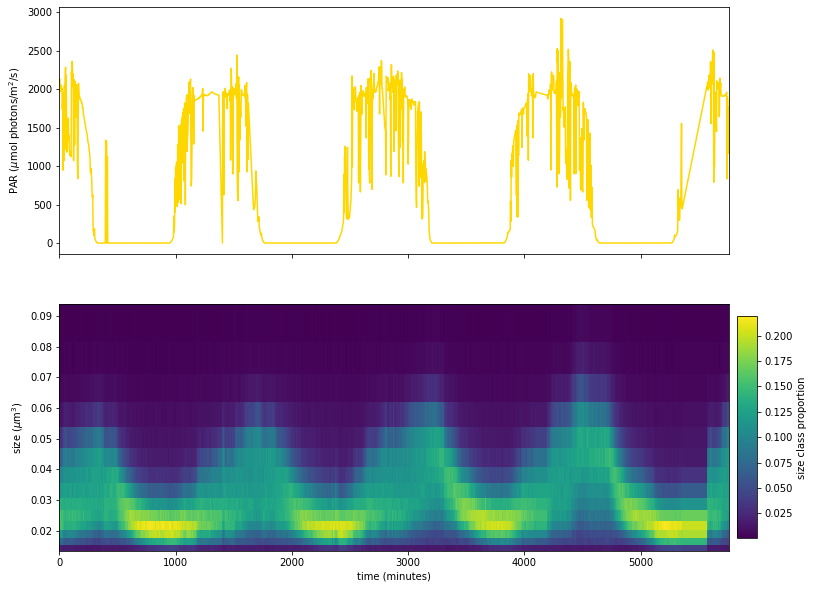

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

fig,axs = plt.subplots(nrows=2, sharex=True, figsize=(12,10))

ax = axs[0]
ax.plot(data_seaflow['time'], data_seaflow['PAR'], color='gold')
ax.set(ylabel='PAR ($\mu$mol photons/m$^{2}$/s)')

ax = axs[1]
pc = ax.pcolormesh(data_seaflow['time'],v,data_seaflow['w_obs'])
ax.set(ylabel='size ($\mu$m$^3$)', xlabel='time (minutes)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [4]:
# prepare data for Stan model

dt = 20 # in units of minutes

data = {'dt':dt}
for k in ('m','v_min','delta_v_inv'):
    data[k] = data_seaflow[k]

data['obs'] = data_seaflow['w_obs']
data['t_obs'] = data_seaflow['time']
data['E'] = data_seaflow['PAR']
# use first measurements as initial conditions
data['w_ini'] = data_seaflow['w_obs'][:,0]

# limit the data

limit_days = 2
stride_t_obs = 20

# remove very first observations
ind_obs = data['t_obs'] > 3
data['t_obs'] = data['t_obs'][ind_obs]
data['obs'] = data['obs'][:,ind_obs]

if limit_days > 0:
    limit_minutes = limit_days*1440
    
    ind_obs = data['t_obs'] < limit_minutes
    data['t_obs'] = data['t_obs'][ind_obs]
    data['obs'] = data['obs'][:,ind_obs]

    data['nt'] = int(limit_minutes//data['dt'])
    
if stride_t_obs > 0:
    data['t_obs'] = data['t_obs'][::stride_t_obs]
    data['obs'] = data['obs'][:,::stride_t_obs]

data['nt_obs'] = data['obs'].shape[1]
    
# finally, add light data
t = np.arange(data['nt'])*data['dt']
data['E'] = np.interp(t, xp=data_seaflow['time'], fp=data_seaflow['PAR'])

In [5]:
import pystan

model = pystan.StanModel(file='stancode/matrixmodel_sigmoidaldelta.stan', model_name='matrixmodel_sigmoidaldelta', obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL matrixmodel_sigmoidaldelta NOW.


In [6]:
mcmc = model.sampling(data=data, iter=2000)
print('\n'.join(x for x in mcmc.__str__().split('\n') if 'mod_obspos' not in x))

Inference for Stan model: matrixmodel_sigmoidaldelta.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           3.83    0.03   0.79   2.67   3.28   3.69   4.21   5.84    947    1.0
gamma_max          28.17    0.05   2.43   23.4  26.53  28.16  29.82   32.9   2145    1.0
sig_offset          0.04  8.7e-5 2.6e-3   0.03   0.03   0.03   0.04   0.04    924    1.0
sig_steepness     236.78    2.05  72.57 122.39 184.45 227.47 279.14 407.24   1253    1.0
E_star            3000.2    0.18   9.99 2980.4 2993.2 3000.4 3007.0 3019.2   2977    1.0
sigma               0.12  1.3e-4 6.3e-3    0.1   0.11   0.12   0.12   0.13   2400    1.0
lp__              -135.5    0.05   1.82 -139.9 -136.5 -135.2 -134.2 -133.0   1355    1.0

Samples were drawn using NUTS at Tue Jan 21 08:47:25 2020.
For each parameter, n_eff is a crude measure of effectiv

## Plot the results

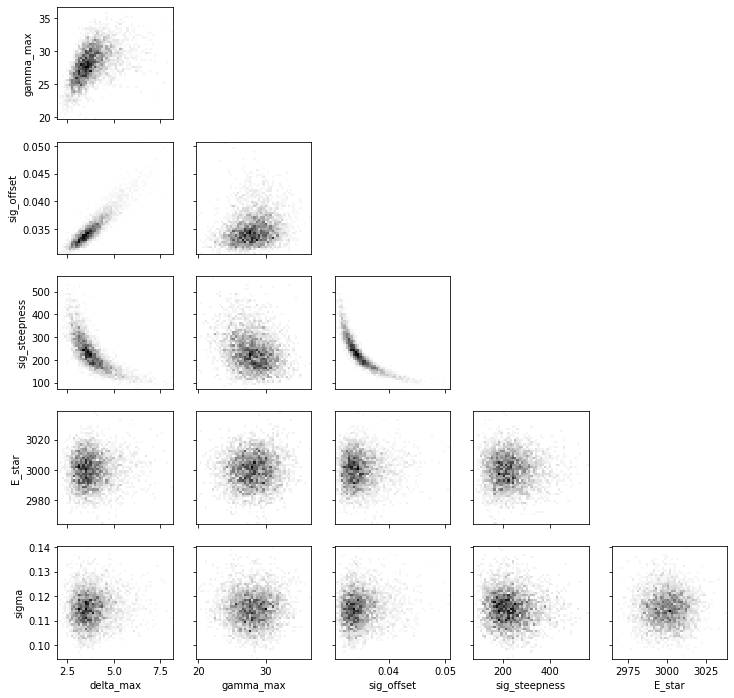

In [7]:
paramnames = [v for v in mcmc.flatnames if not v.startswith('mod_obspos')]
num_params = len(paramnames)

fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
for ax in axs.flat:
    ax.set_visible(False)
for irow in range(1,num_params):
    for icol in range(irow):
        ax = axs[irow-1,icol]
        ax.set_visible(True)
        xname = paramnames[icol]
        yname = paramnames[irow]
        ax.hist2d(mcmc[xname],mcmc[yname],bins=50,cmap=mpl.cm.gray_r)
        if icol == 0:
            ax.set_ylabel(yname)
        if irow == num_params-1:
            ax.set_xlabel(xname)

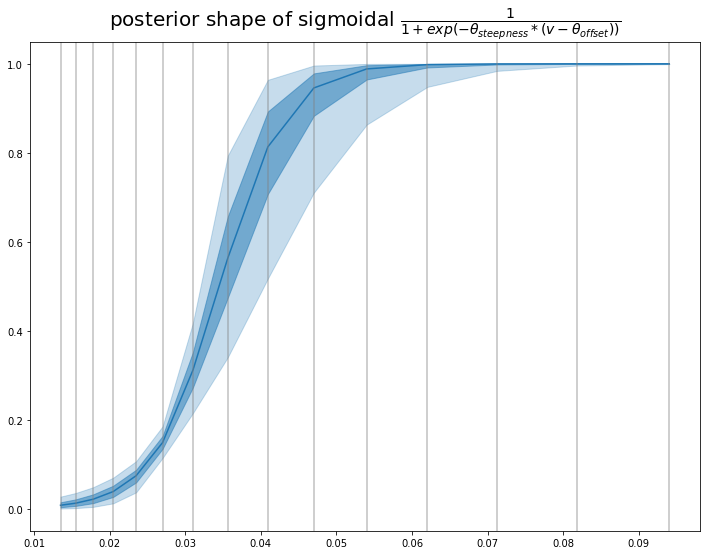

In [8]:
m = data['m']
num_samples = mcmc['sig_offset'].shape[0]
tmp = np.full((num_samples,m), fill_value=np.nan)
for irow in range(num_samples):
    tmp[irow,:] = 1.0/(1.0+np.exp(-mcmc['sig_steepness'][irow]*(v-mcmc['sig_offset'][irow])))
    
quantiles = np.percentile(tmp, q=(5,25,50,75,95), axis=0)    

fig, ax = plt.subplots(figsize=(12,9))
ax.fill_between(x=v, y1=quantiles[0,:], y2=quantiles[-1,:], alpha=0.25, color='C0')
ax.fill_between(x=v, y1=quantiles[1,:], y2=quantiles[-2,:], alpha=0.5, color='C0')
ax.plot(v, quantiles[2,:], color='C0')
for vi in v:
    ax.axvline(vi, color='.5', alpha=0.5)
ax.set_title('posterior shape of sigmoidal $\\frac{1}{1+exp(-\\theta_{steepness}*(v-\\theta_{offset}))}$', size=20)
None

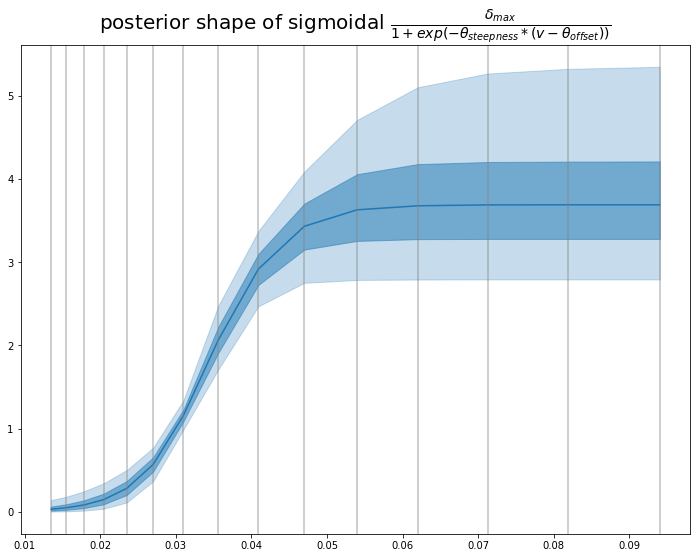

In [9]:
num_samples = mcmc['sig_offset'].shape[0]
tmp = np.full((num_samples,m), fill_value=np.nan)
for irow in range(num_samples):
    tmp[irow,:] = mcmc['delta_max'][irow]/(1.0+np.exp(-mcmc['sig_steepness'][irow]*(v-mcmc['sig_offset'][irow])))
    
quantiles = np.percentile(tmp, q=(5,25,50,75,95), axis=0)    

fig, ax = plt.subplots(figsize=(12,9))
ax.fill_between(x=v, y1=quantiles[0,:], y2=quantiles[-1,:], alpha=0.25, color='C0')
ax.fill_between(x=v, y1=quantiles[1,:], y2=quantiles[-2,:], alpha=0.5, color='C0')
ax.plot(v, quantiles[2,:], color='C0')
for vi in v:
    ax.axvline(vi, color='.5', alpha=0.5)
ax.set_title('posterior shape of sigmoidal $\\frac{\\delta_{max}}{1+exp(-\\theta_{steepness}*(v-\\theta_{offset}))}$', size=20)
None

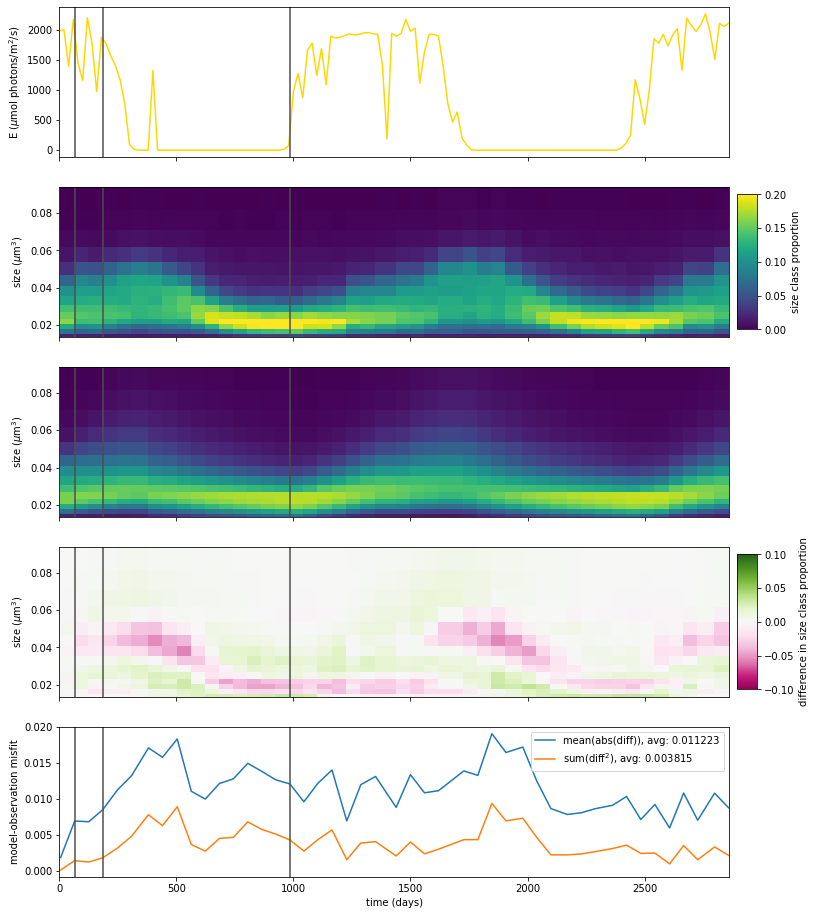

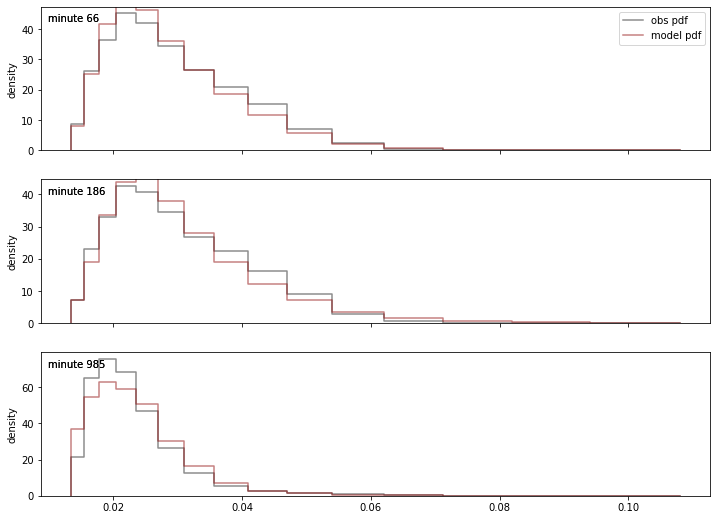

In [10]:
res = {'model':np.mean(mcmc['mod_obspos'], axis=0), 'obs':data['obs']}
colors = {'model':'darkred', 'obs':'0.1'}

diff = res['model']-res['obs']

t = data['dt']*np.arange(data['nt'])
slice_indices = [1,3,16]
v_ext = data['v_min'] * 2**(np.arange(data['m']+1)*delta_v) 
v_width = v_ext[1:] - v_ext[:-1]

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

fig,axs = plt.subplots(5,1,sharex=True,figsize=(12,16))

ax = axs[0]
ax.plot(t, data['E'], color='gold')
ax.set(xlim=(t[0],t[-1]), ylabel='E ($\mu$mol photons/m$^{2}$/s)')

ax = axs[1]
pc = ax.pcolormesh(data['t_obs'],v,res['obs'],norm=norm)
ax.set(ylabel='size ($\mu$m$^3$)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

ax = axs[2]
ax.set(ylabel='size ($\mu$m$^3$)')
pc = ax.pcolormesh(data['t_obs'],v,res['model'],norm=norm)

ax = axs[3]
pc = ax.pcolormesh(data['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
ax.set(ylabel='size ($\mu$m$^3$)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

ax = axs[4]
prop = np.mean(np.abs(diff),axis=0)
ax.plot(data['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
prop = np.sum(diff**2,axis=0)
ax.plot(data['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
ax.set(xlabel='time (days)', ylabel='model-observation misfit')
ax.legend()

for ax in axs.flat:
    for i in slice_indices:
        ax.axvline(data['t_obs'][i], color='.3')

# plot slices

plotdata_y = np.zeros(2*(data['m']+1))

fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
for i,ax in zip(slice_indices,axs.flat):
    for name in ('obs','model'):
        color = colors[name]
        cdata = res[name][:,i]
        plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
        ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
        ax.text(0.01, 0.95, 'minute {}'.format(data['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
        ax.set_ylabel('density')
        ax.set_ylim(bottom=0.0)
axs[0].legend()
None